In [1]:
import warnings
warnings.filterwarnings('ignore')

from os import path
from typing import List, Union

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length,plotFig
from sklearn.preprocessing import MinMaxScaler

from TSB_UAD.models.sand import SAND

<h1>Generate Dataset</h1>

In [2]:
base_path = "TSB-UAD-Public"

def read_dataset_as_df(filepath):
    df = pd.read_csv(filepath, header=None).dropna()
    df[0] = df[0].astype(float) # assuming univariate
    df[1] = df[1].astype(int)   # label
    return df

def generate_dataset(filepaths: List[str], sample_size: Union[int,float]=None):
    
    # Read
    filepaths = [path.join(base_path, fp) for fp in filepaths]
    normality = len(filepaths)
    datasets = [read_dataset_as_df(fp) for fp in filepaths]
    
    # Sampling
    if sample_size is not None:
        if sample_size <= 1:  # sample size was defined as a percentage of the original series' size
            sample_size = [dataset.shape[0] * sample_size for dataset in datasets]
        else: # sample size was defined as maximun number of points
            sample_size = [min(dataset.shape[0], sample_size) for dataset in datasets]
            
        for i, (dataset_sample_size, dataset) in enumerate(zip(sample_size, datasets)):
            datasets[i] = dataset[:dataset_sample_size]
    
    # Concatenate
    shift_idxs = []
    if len(datasets) > 1:
        cumulative_length = 0
        for i, dataset in enumerate(datasets[:-1]):
            cumulative_length += len(dataset)
            shift_idxs.append(cumulative_length)
            
    # Concatenate the list of DataFrames along rows (axis=0)
    merged_dataset = pd.concat(datasets, ignore_index=True)
    return merged_dataset, normality, shift_idxs



In [3]:

def _plot_generated_dataset(df: pd.DataFrame,
                           x_values,
                           shift_idxs=None):
    
    y_values = df[0].values         # First column ('0') values as y-values
    color_values = df[1].values     # Second column ('1') values for coloring (0 or 1)

    # Plotting the time series with conditional coloring
    plt.figure(figsize=(12,4))  # Set the figure size (width, height)

    # Plot the entire time series as a line plot
    plt.plot(x_values, y_values, color='black', linewidth=2)

    # Initialize segment start index and color
    segment_start = 0
    current_color = color_values[0]

    # Iterate over data points to plot line segments with different colors
    for i in range(1, len(df)):
        if color_values[i] != current_color:
            # Plot the previous segment with the current color
            plt.plot(x_values[segment_start:i], y_values[segment_start:i], color='red' if current_color == 1 else 'black', linewidth=2)
            # Update segment start index and current color
            segment_start = i
            current_color = color_values[i]

    # Plot the last segment
    plt.plot(x_values[segment_start:], y_values[segment_start:], color='red' if current_color == 1 else 'black', linewidth=2)
    
    for shift_idx in shift_idxs:
        plt.axvline(shift_idx, color='blue', linestyle='--', linewidth=1.5)

    # Display the plot
    plt.show()

def plot_generated_dataset(df: pd.DataFrame, 
                           plot_around_distro_shifts=False, 
                           plot_range=1000,
                           shift_idxs: List[int]=None):
    
    # Extract values from DataFrame
    if plot_around_distro_shifts and shift_idxs is not None and len(shift_idxs) > 0:
        for shift_idx in shift_idxs:  # different plot for each distro shift
            x_values = np.arange(shift_idx - plot_range, shift_idx + plot_range + 1)
            df_partial = df.loc[x_values]
            _plot_generated_dataset(df_partial, x_values, [shift_idx])
    
    else:
        x_values = np.arange(len(df))  # Use numerical index as x-values
        _plot_generated_dataset(df, x_values, shift_idxs)


Series len = 200000
Normality = 2
Distro shift indexes = [100000]


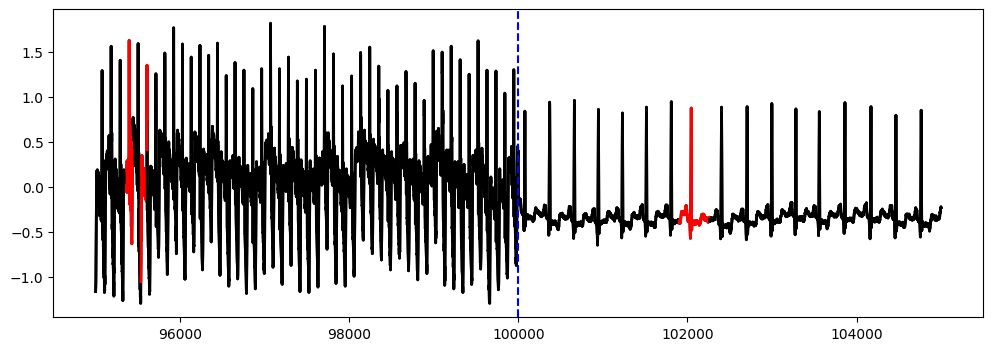

In [18]:
dataset1_path = 'ECG/MBA_ECG801_data.out'
dataset2_path = 'MITDB/100.test.csv@1.out'
filepaths = [dataset1_path, dataset2_path]
df, normality, shift_idxs = generate_dataset(filepaths, sample_size=100000)

print(f"Series len = {df.shape[0]}\nNormality = {normality}\nDistro shift indexes = {shift_idxs}")
plot_generated_dataset(df, plot_around_distro_shifts=True, plot_range=5000, shift_idxs=shift_idxs)


<h1>Test SAND method</h1>

In [16]:
data = df[0]
label = df[1]
slidingWindow = find_length(data)

print("Estimated Subsequence length: ",slidingWindow)
print("Time series length: ",len(data))
print("Number of abnormal points: ",list(label).count(1))


Estimated Subsequence length:  147
Time series length:  200000
Number of abnormal points:  26030


0-->5000-->7000-->9000-->11000-->13000-->15000-->17000-->19000-->21000-->23000-->25000-->27000-->29000-->31000-->33000-->35000-->37000-->39000-->41000-->43000-->45000-->47000-->49000-->51000-->53000-->55000-->57000-->59000-->61000-->63000-->65000-->67000-->69000-->71000-->73000-->75000-->77000-->79000-->81000-->83000-->85000-->87000-->89000-->91000-->93000-->95000-->97000-->99000-->101000-->103000-->105000-->107000-->109000-->111000-->113000-->115000-->117000-->119000-->121000-->123000-->125000-->127000-->129000-->131000-->133000-->135000-->137000-->139000-->141000-->143000-->145000-->147000-->149000-->151000-->153000-->155000-->157000-->159000-->161000-->163000-->165000-->167000-->169000-->171000-->173000-->175000-->177000-->179000-->181000-->183000-->185000-->187000-->189000-->191000-->193000-->195000-->197000-->199000-->[STOP]: score length 200000


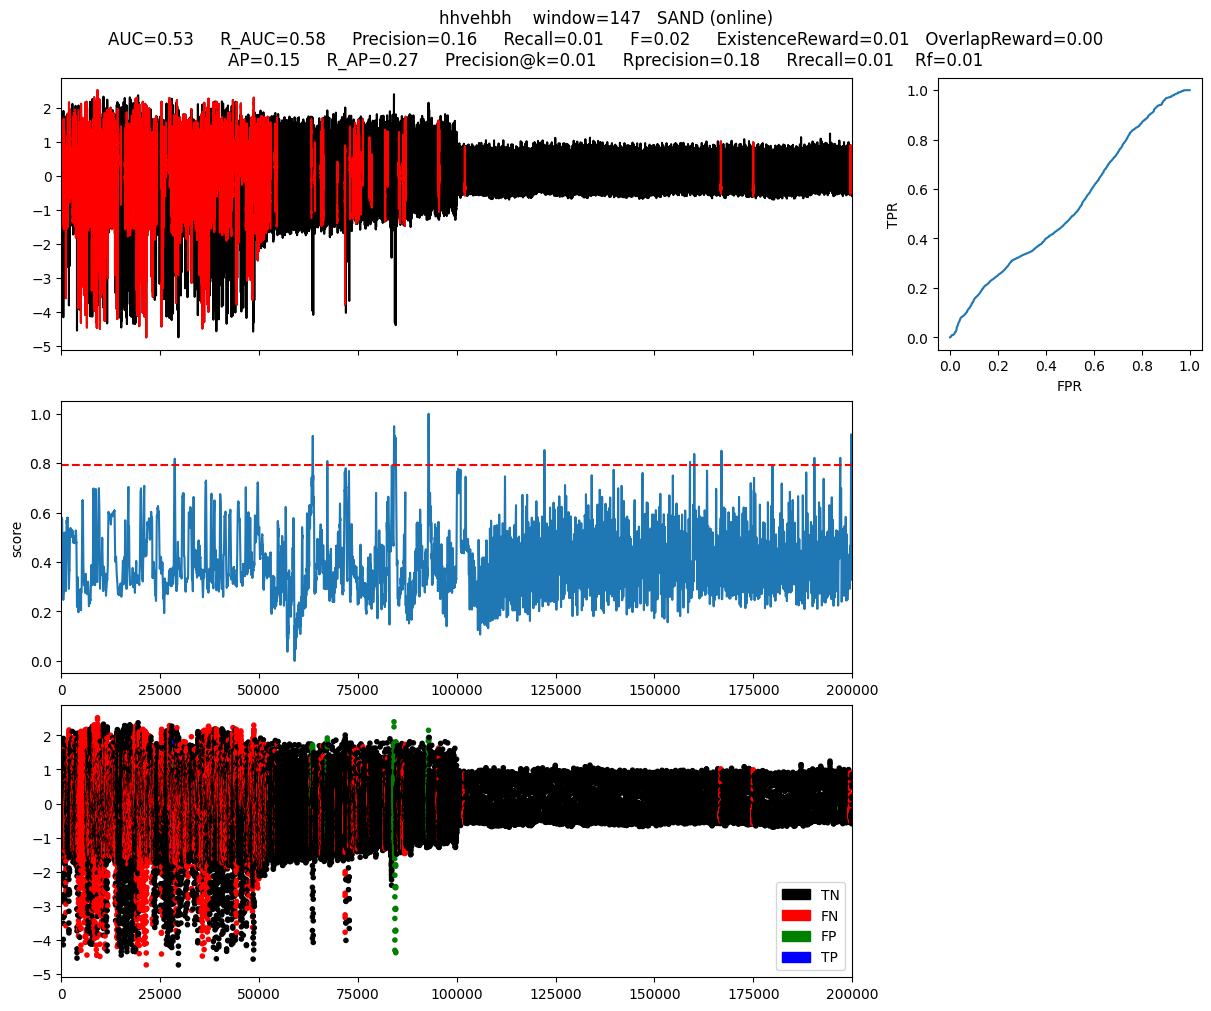

In [17]:
name = "hhvehbh"
modelName='SAND (online)'
clf = SAND(pattern_length = slidingWindow, subsequence_length = 4*(slidingWindow))
x = data
clf.fit(x, online=True, alpha=0.5, init_length=5000, batch_size=2000, verbose=True, overlaping_rate=int(4*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)
